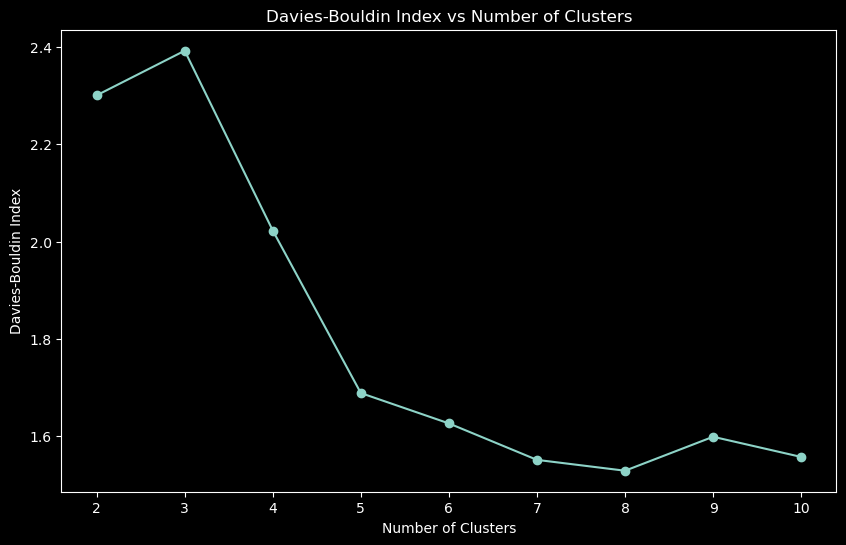

Optimal number of clusters: 8
Davies-Bouldin Index: 1.5285


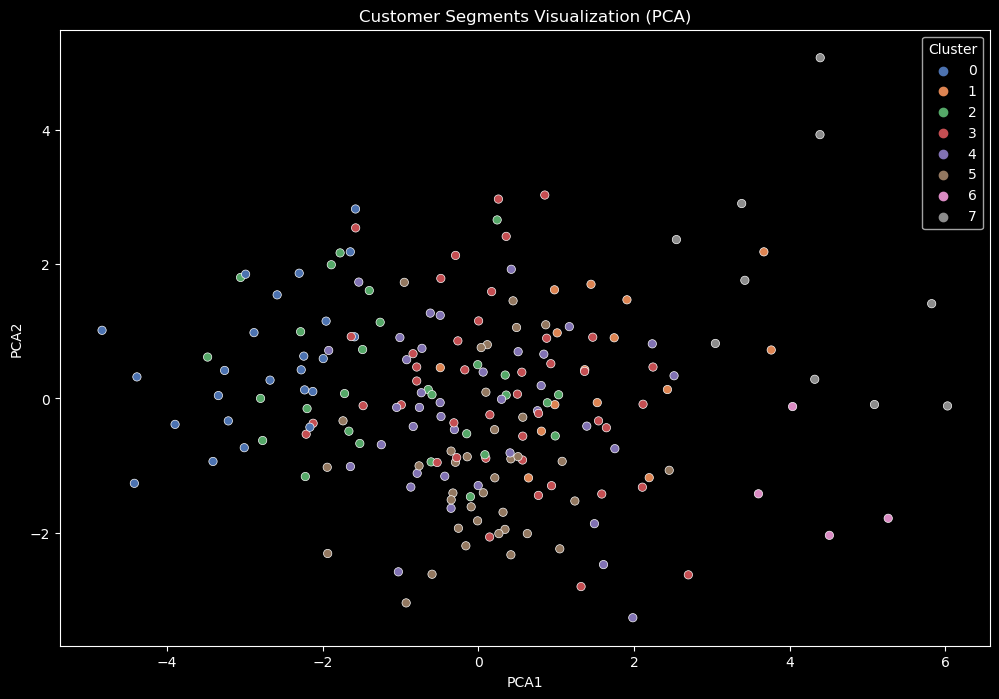

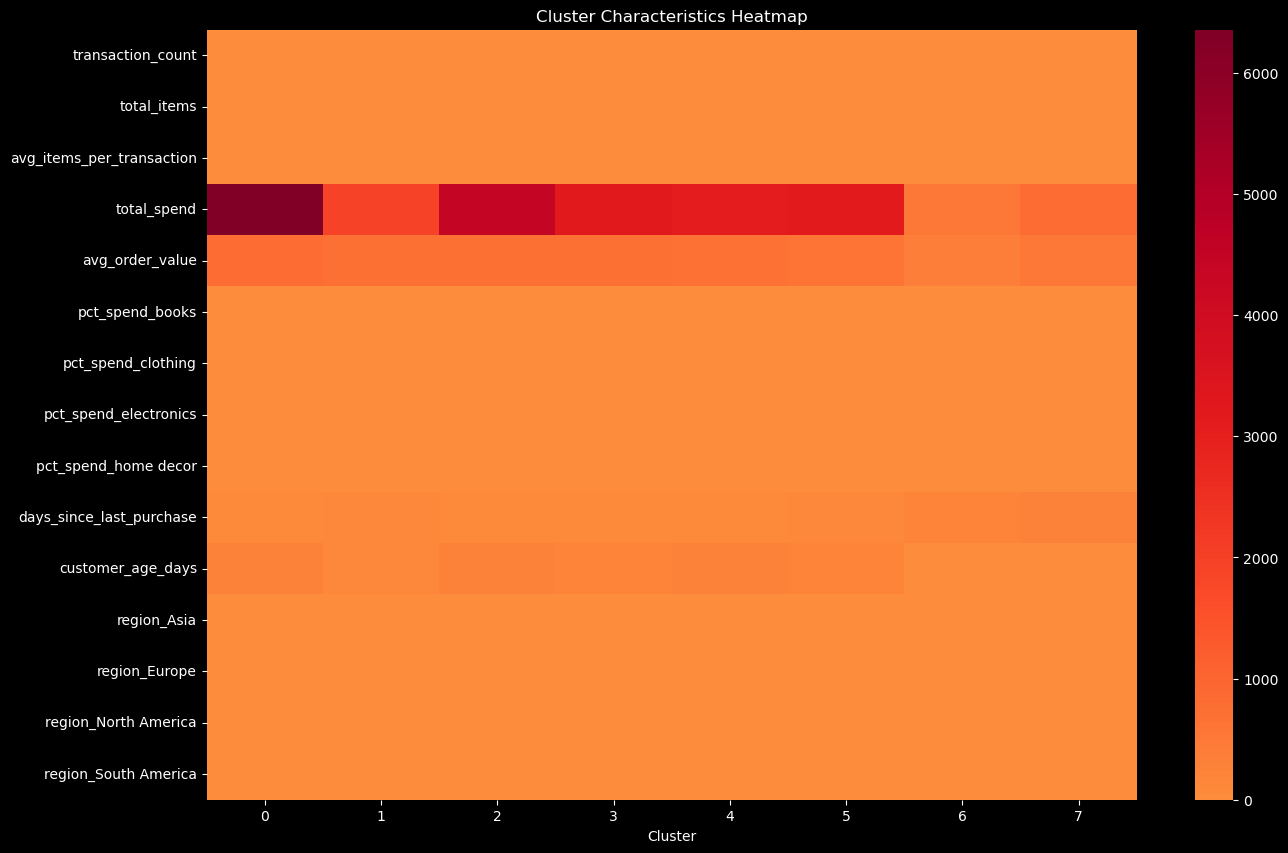


Cluster Sizes:
0    24
1    15
2    28
3    43
4    38
5    37
6     4
7    10
Name: count, dtype: int64

Key Characteristics of Each Cluster:

Cluster 0:
total_spend: 6355.06
avg_order_value: 830.79
customer_age_days: 274.62
days_since_last_purchase: 66.00
total_items: 22.46

Cluster 1:
total_spend: 1980.43
avg_order_value: 729.17
days_since_last_purchase: 137.27
customer_age_days: 128.47
total_items: 6.87

Cluster 2:
total_spend: 4430.76
avg_order_value: 718.74
customer_age_days: 268.68
days_since_last_purchase: 80.54
total_items: 16.57

Cluster 3:
total_spend: 3260.20
avg_order_value: 713.15
customer_age_days: 229.53
days_since_last_purchase: 97.63
total_items: 11.63

Cluster 4:
total_spend: 3091.52
avg_order_value: 650.04
customer_age_days: 249.08
days_since_last_purchase: 91.37
total_items: 11.39

Cluster 5:
total_spend: 3128.33
avg_order_value: 641.81
customer_age_days: 243.54
days_since_last_purchase: 102.59
total_items: 12.14

Cluster 6:
total_spend: 510.29
avg_order_value: 39

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Convert dates to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

def create_customer_features(customers_df, transactions_df, products_df):
    """
    Create feature matrix for customers based on their profile and transaction history
    """
    # Merge transactions with products
    trans_prod = transactions_df.merge(products_df, on='ProductID')
    
    # Calculate customer transaction features
    # Basic transaction metrics
    transaction_metrics = trans_prod.groupby('CustomerID').agg({
        'TransactionID': 'count',          # Number of transactions
        'Quantity': ['sum', 'mean'],       # Total items and average items per transaction
        'TotalValue': ['sum', 'mean']      # Total spend and average order value
    })
    
    # Flatten column names
    transaction_metrics.columns = [
        'transaction_count',
        'total_items',
        'avg_items_per_transaction',
        'total_spend',
        'avg_order_value'
    ]
    
    # Category preferences (percentage of spend in each category)
    category_spend = trans_prod.pivot_table(
        index='CustomerID',
        columns='Category',
        values='TotalValue',
        aggfunc='sum',
        fill_value=0
    )
    
    # Calculate percentage spend in each category
    category_spend_pct = category_spend.div(category_spend.sum(axis=1), axis=0)
    category_spend_pct.columns = [f'pct_spend_{col.lower()}' for col in category_spend_pct.columns]
    
    # Combine all features
    customer_features = transaction_metrics.join(category_spend_pct)
    
    # Add recency and frequency features
    last_transaction = trans_prod.groupby('CustomerID')['TransactionDate'].max()
    first_transaction = trans_prod.groupby('CustomerID')['TransactionDate'].min()
    customer_features['days_since_last_purchase'] = (pd.Timestamp.now() - last_transaction).dt.days
    customer_features['customer_age_days'] = (last_transaction - first_transaction).dt.days
    
    # Add region as dummy variables
    region_dummies = pd.get_dummies(customers_df.set_index('CustomerID')['Region'], prefix='region')
    customer_features = customer_features.join(region_dummies)
    
    return customer_features

def find_optimal_clusters(scaled_data, max_clusters=10):
    """
    Find optimal number of clusters using Davies-Bouldin Index
    """
    db_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(scaled_data)
        db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
        db_scores.append(db_score)
    
    # Plot Davies-Bouldin scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), db_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index vs Number of Clusters')
    plt.show()
    
    # Return optimal number of clusters (minimum DB score)
    optimal_clusters = db_scores.index(min(db_scores)) + 2
    return optimal_clusters, db_scores

def visualize_clusters(scaled_data, labels):
    """
    Visualize clusters using PCA
    """
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'PCA1': pca_result[:, 0],
        'PCA2': pca_result[:, 1],
        'Cluster': labels
    })
    
    # Plot clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=plot_df, x='PCA1', y='PCA2', hue='Cluster', palette='deep')
    plt.title('Customer Segments Visualization (PCA)')
    plt.show()

def analyze_clusters(customer_features, labels):
    """
    Analyze characteristics of each cluster
    """
    # Add cluster labels to features
    cluster_df = customer_features.copy()
    cluster_df['Cluster'] = labels
    
    # Calculate mean values for each cluster
    cluster_means = cluster_df.groupby('Cluster').mean()
    
    # Create heatmap of cluster characteristics
    plt.figure(figsize=(15, 10))
    sns.heatmap(cluster_means.T, cmap='YlOrRd', center=0)
    plt.title('Cluster Characteristics Heatmap')
    plt.show()
    
    return cluster_means

# Create and scale features
customer_features = create_customer_features(customers_df, transactions_df, products_df)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

# Find optimal number of clusters
optimal_clusters, db_scores = find_optimal_clusters(scaled_features)
print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {min(db_scores):.4f}")

# Perform clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Visualize clusters
visualize_clusters(scaled_features, cluster_labels)

# Analyze cluster characteristics
cluster_means = analyze_clusters(customer_features, cluster_labels)

# Save cluster assignments
cluster_assignments = pd.DataFrame({
    'CustomerID': customer_features.index,
    'Cluster': cluster_labels
})
cluster_assignments.to_csv('customer_segments.csv', index=False)

# Print cluster sizes
print("\nCluster Sizes:")
print(pd.Series(cluster_labels).value_counts().sort_index())

# Print key characteristics of each cluster
print("\nKey Characteristics of Each Cluster:")
for cluster in range(optimal_clusters):
    print(f"\nCluster {cluster}:")
    # Get top 5 distinguishing features
    cluster_features = cluster_means.loc[cluster].sort_values(ascending=False)[:5]
    for feature, value in cluster_features.items():
        print(f"{feature}: {value:.2f}")